In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/27-class-sign-language-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/27-class-sign-language-dataset/Y.npy
/kaggle/input/27-class-sign-language-dataset/X.npy


In [2]:
#Load features (images) and labels
X = np.load('/kaggle/input/27-class-sign-language-dataset/X.npy')
y = np.load('/kaggle/input/27-class-sign-language-dataset/Y.npy')

In [3]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


2025-05-03 19:55:11.709998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746302111.947029      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746302112.011681      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def resize_images(images, target_size=(128,128)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)

X_resized = resize_images(X)

In [5]:
images = X.astype('float32')
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(y.reshape(-1))
y_categorical = to_categorical(labels)

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,  
    fill_mode='nearest'
)
X_train, X_val, y_train, y_val = train_test_split(
    X_resized, y_categorical, test_size=0.2, random_state=42
)
# Create generator for training
train_generator = train_datagen.flow(
    x=X_train,
    y=y_train,
    batch_size=32,
    shuffle=True
)

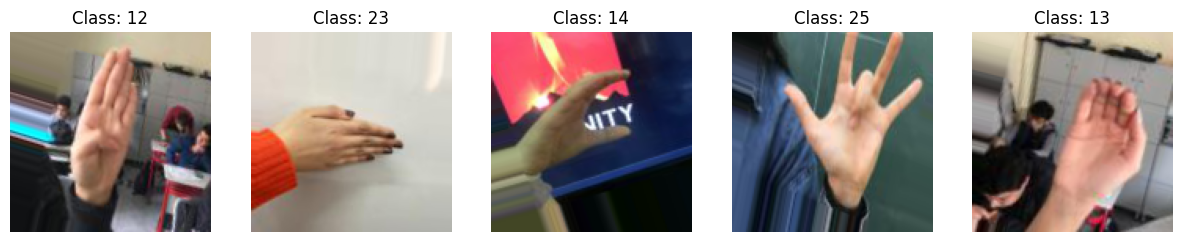

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(images, labels, num_samples=5, augmentation_type="Original"):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        
        # For grayscale images (single channel)
        if images[i].shape[-1] == 1:
            plt.imshow(images[i].squeeze(), cmap='gray')
        else:
            plt.imshow(images[i])
            
        plt.title(f"{augmentation_type}\nClass: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

# Generate a batch of augmented images
aug_images, aug_labels = next(train_generator)  # Correct syntax

# Plot samples
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    
    # For grayscale images (1 channel)
    if aug_images[i].shape[-1] == 1:
        plt.imshow(aug_images[i].squeeze(), cmap='gray')
    else:
        plt.imshow(aug_images[i])
    
    plt.title(f"Class: {np.argmax(aug_labels[i])}")
    plt.axis('off')
plt.show()

In [8]:
# Create a validation generator using ImageDataGenerator
val_datagen = ImageDataGenerator() # No augmentation 
val_generator = val_datagen.flow(
    x=X_val,
    y=y_val,
    batch_size=32,
    shuffle=False 
)

I0000 00:00:1746302135.050854      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746302135.051470      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


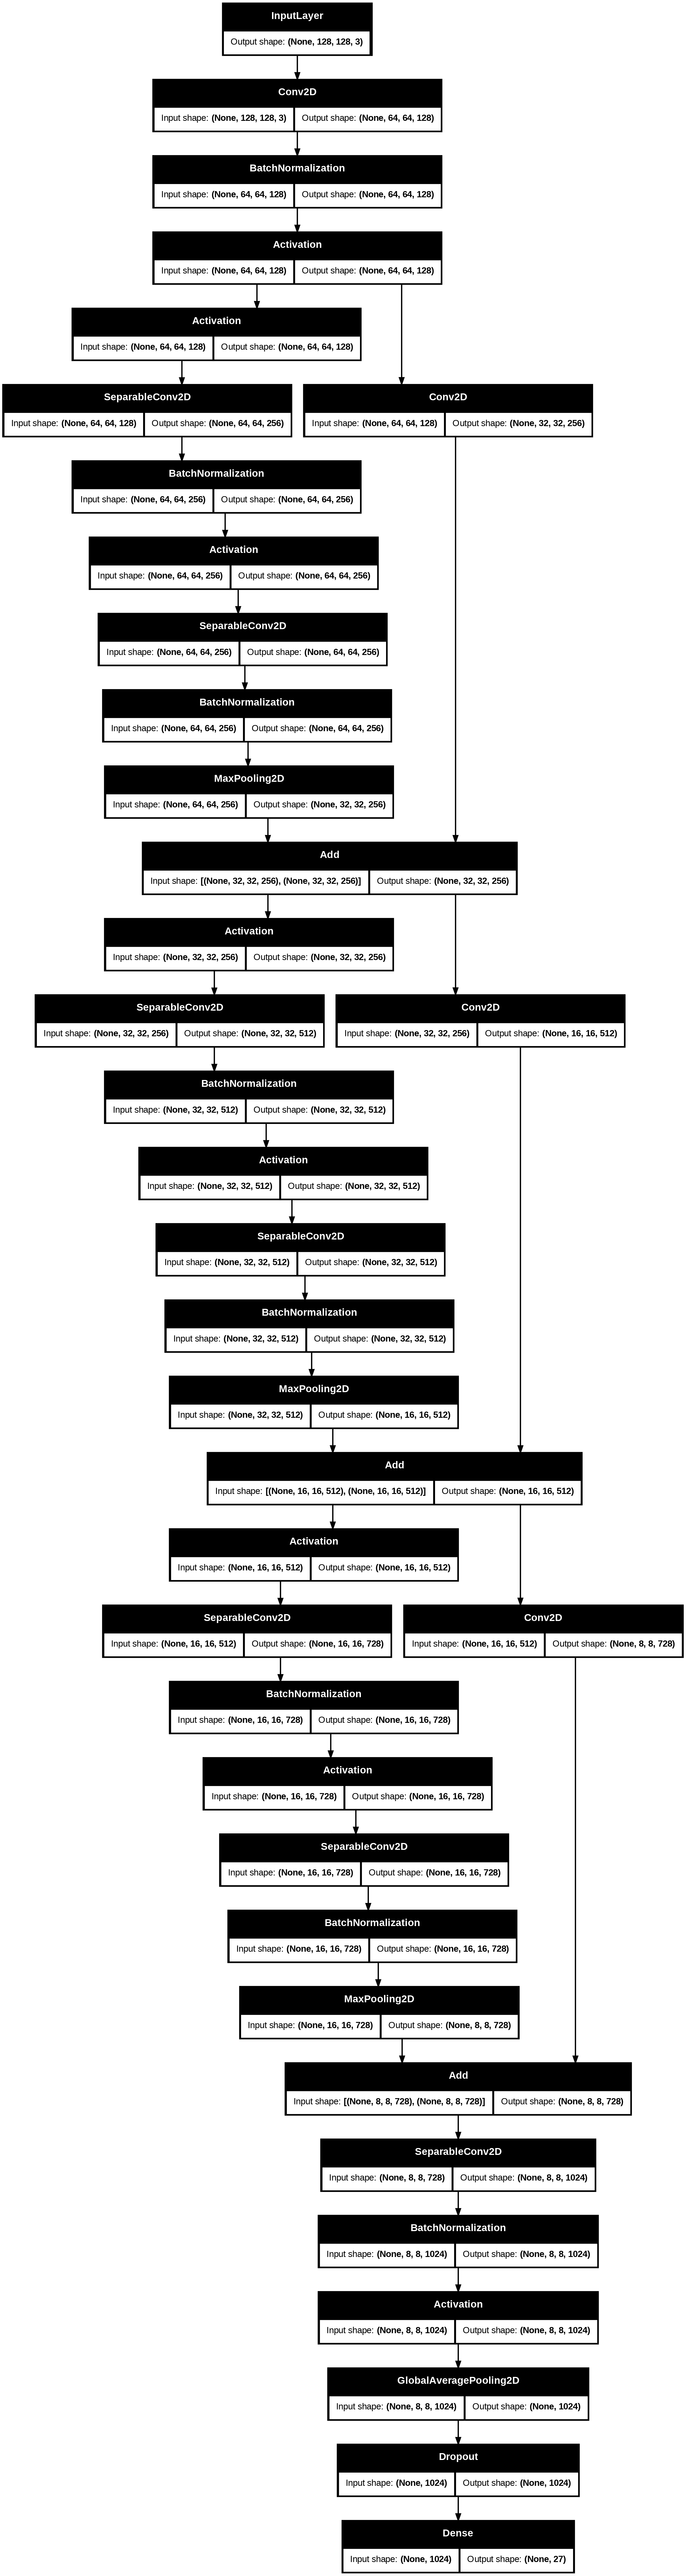

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow import keras
from tensorflow.keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(inputs) 
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x 

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)

  
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)


    return keras.Model(inputs, outputs)

model = make_model((128, 128, 3), num_classes=27)

keras.utils.plot_model(model, show_shapes=True)

In [10]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)


history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val,y_val),
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746302149.557129      96 service.cc:148] XLA service 0x788d3c002390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746302149.558132      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746302149.558156      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746302150.511156      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1746302157.226851      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

  1/570 ━━━━━━━━━━━━━━━━━━━━ 4:09:18 26s/step - accuracy: 0.0625 - loss: 3.5467

I0000 00:00:1746302165.023017      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


570/570 ━━━━━━━━━━━━━━━━━━━━ 101s 132ms/step - accuracy: 0.1581 - loss: 2.9132 - val_accuracy: 0.0235 - val_loss: 4.5232
Epoch 2/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 83s 144ms/step - accuracy: 0.6423 - loss: 1.1505 - val_accuracy: 0.6652 - val_loss: 1.0242
Epoch 3/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 84s 146ms/step - accuracy: 0.8272 - loss: 0.5835 - val_accuracy: 0.8191 - val_loss: 0.5761
Epoch 4/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 85s 148ms/step - accuracy: 0.8864 - loss: 0.3836 - val_accuracy: 0.7770 - val_loss: 0.6612
Epoch 5/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 85s 148ms/step - accuracy: 0.9090 - loss: 0.2989 - val_accuracy: 0.8759 - val_loss: 0.3902
Epoch 6/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 86s 149ms/step - accuracy: 0.9259 - loss: 0.2595 - val_accuracy: 0.7865 - val_loss: 0.6671
Epoch 7/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 86s 149ms/step - accuracy: 0.9323 - loss: 0.2262 - val_accuracy: 0.8202 - val_loss: 0.6223
Epoch 8/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 85s 148ms/step - accuracy: 0.9413 - loss: 0.1830 - va

In [11]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8715 - loss: 0.3962
Validation Accuracy: 87.81%
Validation Loss: 0.3835


/tmp/ipykernel_31/2073114451.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


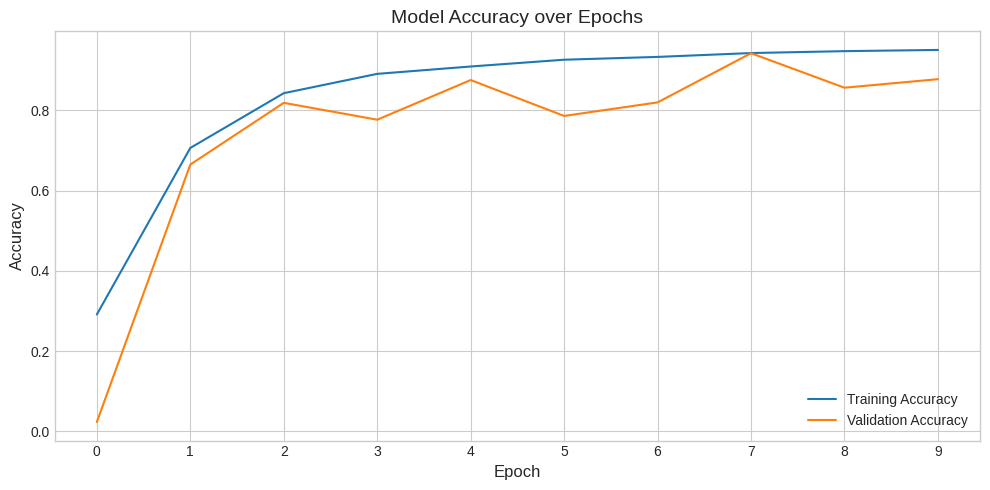

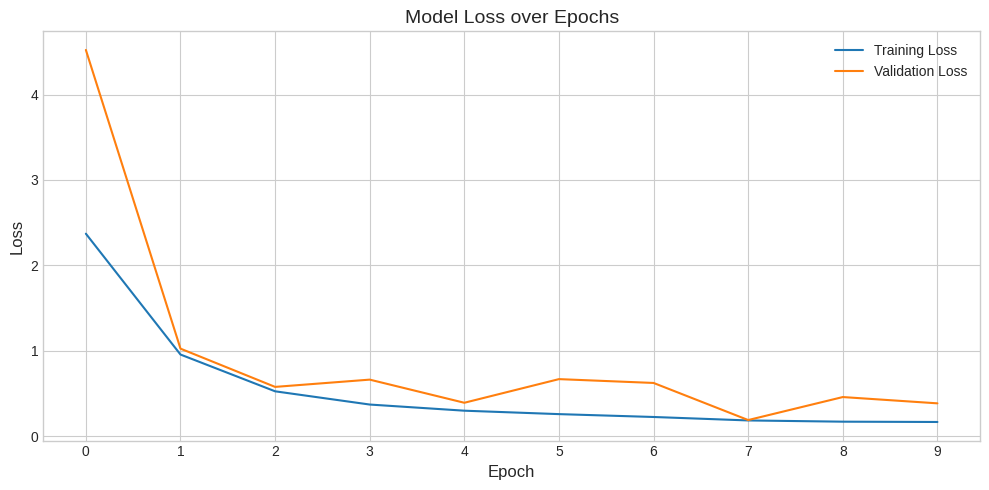

In [12]:
plt.style.use('seaborn-whitegrid')  

def plot_training_history(history):
    epochs = range(len(history.history['accuracy']))

    # Accuracy Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(epochs)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.xticks(epochs)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)

In [13]:
!pip install lime

In [14]:
#LIME
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [15]:
img_tensor = X_val[i]  
img = np.array(img_tensor) 

In [16]:
np_img = (img_tensor * 255).astype(np.uint8)

np_img_rgb = np.transpose(np_img, (0, 2, 1)) 
np_img = (np_img * 255).astype(np.uint8)

In [17]:
def predict(images):
    images = np.array(images).astype('float32') / 255.0 
    return model.predict(images)

In [18]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np_img, predict, top_labels=1, num_features=10, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━

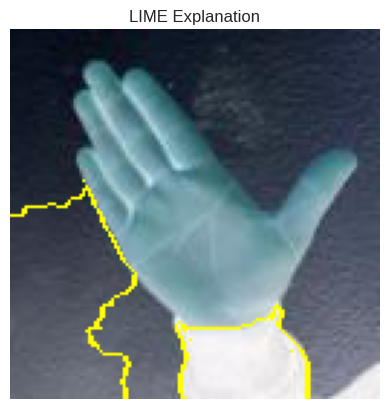

In [19]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis("off")
plt.show()

In [22]:
!pip install shap
import shap

143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

  0%|          | 0/498 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


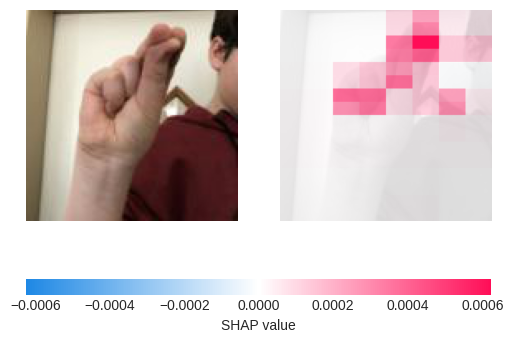

In [24]:
import shap
from shap.maskers import Image
import numpy as np
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]
test_images = X_val[misclassified_indices[:1]]  
preds = model.predict(test_images)
pred_class = np.argmax(preds[0])
masker = Image("blur(128,128)", test_images[0].shape)
explainer = shap.Explainer(lambda x: model.predict(x)[:, pred_class], masker)
shap_values = explainer(test_images)
shap.plots.image(shap_values)


In [35]:
#Grad-CAM
# Clear previous hooks
gradients = []
activations = []

gradients.clear()
activations.clear()

# Re-register hooks using full backward hook
def save_activation(module, input, output):
    activations.append(output)

def save_gradient(module, grad_input, grad_output):
    gradients.append(grad_output[0])

In [42]:
import tensorflow as tf

# Assuming img_tensor is now a NumPy array with shape (1, 128, 128, 3)

# Run prediction with the model (ensure it's a Keras model)
output = model(img_tensor)  # Assuming model is a Keras model

# Get predicted class (use tf.argmax() for EagerTensor)
pred_class = tf.argmax(output, axis=-1).numpy().item()

# If you want to do a backward pass, it is not directly supported in Keras as it's an eager execution framework


In [47]:
# Compute Grad-CAM
grad = gradients[0]  # shape: [1, C, H, W]
act = activations[0]  # shape: [1, C, H, W]
weights = grad.mean(dim=[2, 3], keepdim=True)
cam = (weights * act).sum(dim=1).squeeze().cpu().detach().numpy()
cam = np.maximum(cam, 0)
cam = cam / cam.max()
cam = cv2.resize(cam, (256, 256))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

IndexError: list index out of range

In [ ]:
# Overlay
overlay = 0.7 * heatmap + np_img
plt.imshow(overlay.astype(np.uint8))
plt.title("Grad-CAM")
plt.axis("off")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Extract convolutional layers
dream_model = nn.Sequential(*list(model.children())[:-3])
dream_model.eval()
dream_model.to(device)


preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

def deprocess(tensor):
    img = tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    return np.clip(img, 0, 1)

# -------------------------------
# Define DeepDream function
# -------------------------------
def deepdream(image, model, iterations=100, lr=0.001):
    image = image.clone().detach().requires_grad_(True).to(device)

    for i in range(iterations):
        model.zero_grad()
        out = model(image)
        loss = out.norm()
        loss.backward()
        image.data += lr * image.grad.data
        image.grad.data.zero_()
    return image.detach()

image, _ = train_set[1]
image = transforms.ToPILImage()(image)
input_tensor = preprocess(image).unsqueeze(0).to(device)

# -------------------------------
# Apply DeepDream
# -------------------------------
dreamed_tensor = deepdream(input_tensor, dream_model)

plt.figure(figsize=(8, 6))
plt.imshow(deprocess(dreamed_tensor))
plt.title("DeepDream Output (Custom CNN)")
plt.axis("off")
plt.show()

In [73]:
def integrated_gradients(input_image, model, target_class, steps=50):
    baseline = torch.zeros_like(input_image)
    gradients = []
    
    for alpha in torch.linspace(0, 1, steps):
        img = baseline + alpha * (input_image - baseline)
        img.requires_grad_(True)
        
        output = model(img)
        loss = output[0, target_class]
        loss.backward()
        
        gradients.append(img.grad.detach())
        img.grad.zero_()
    
    avg_grads = torch.mean(torch.stack(gradients), dim=0)
    integrated = (input_image - baseline) * avg_grads
    return integrated.squeeze().cpu().numpy()

In [84]:
def integrated_gradients(input_image, model, target_class=None, steps=50, device='cuda'):
    """
    Args:
        input_image: Tensor (or numpy array) of shape [B, C, H, W]
        model: Pretrained model
        target_class: If None, uses model's prediction
        steps: Number of integration steps
        device: 'cuda' or 'cpu'
    """
    # Convert numpy array to tensor if needed
    if isinstance(input_image, np.ndarray):
        input_image = torch.from_numpy(input_image).float()
    
    # Ensure proper device placement
    model = model.to(device).eval()
    input_image = input_image.to(device)
    
    # Get model prediction
    with torch.no_grad():
        output = model(input_image)
        if target_class is None:
            target_class = output.argmax(1).item()  # Get predicted class
    
    # Verify target class is valid
    num_classes = output.shape[1]
    if target_class >= num_classes:
        raise ValueError(f"Target class {target_class} exceeds model's output dimension {num_classes}")
    
    # Baseline (black image)
    baseline = torch.zeros_like(input_image)
    
    # Compute gradients
    gradients = []
    for alpha in torch.linspace(0, 1, steps).to(device):
        # Interpolated image
        img = baseline + alpha * (input_image - baseline)
        img.requires_grad_(True)
        
        # Forward pass
        output = model(img)
        loss = output[0, target_class]
        
        # Backward pass
        loss.backward()
        gradients.append(img.grad.detach())
        img.grad.zero_()
    
    # Compute integrated gradients
    avg_grads = torch.mean(torch.stack(gradients), dim=0)
    integrated = (input_image - baseline) * avg_grads
    
    return integrated.squeeze().cpu().numpy(), target_class

In [85]:
# 1. Load your data (handles both numpy and torch tensors)
test_image = val_generator[0][0]  # Could be numpy array or tensor

# 2. Select single image from batch
if isinstance(test_image, np.ndarray):
    single_image = test_image[0:1]  # numpy style indexing
else:
    single_image = test_image[0:1].clone()  # torch tensor indexing

# 3. Compute attribution
attribution, pred_class = integrated_gradients(
    input_image=single_image,  # Handles either numpy or tensor
    model=model,
    target_class=None,  # Will auto-use model's prediction
    steps=50,
    device='cuda'
)

# 4. Visualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

# Display original image (handles both numpy and tensor)
if isinstance(single_image, torch.Tensor):
    display_img = single_image.squeeze().permute(1, 2, 0).cpu().numpy()
else:
    display_img = single_image.squeeze().transpose(1, 2, 0)
    
plt.imshow(display_img)
plt.title(f"Predicted: {class_names.get(pred_class, str(pred_class))}")
plt.axis('off')

# Display attribution
plt.subplot(1, 2, 2)
plt.imshow(attribution.sum(axis=0), cmap='hot')
plt.title("Feature Importance")
plt.colorbar()
plt.axis('off')
plt.show()

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 128, 128, 3] to have 3 channels, but got 128 channels instead